In [36]:
!pip install cdifflib



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


## CDiffLib

In [124]:
pip install rapidfuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.3 MB/s eta 0:00:00a 0:00:010m

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [173]:
from cdifflib import CSequenceMatcher
import json
import rapidfuzz


def get_close_matches_indexes(phrase, ayat_arr, ayat_info):
    result = []
    # s = CSequenceMatcher()
    # s.set_seq2(phrase)
    corpus =  "".join(ayat_arr)

    char_count = 0
    current_ratio = 0

    for x in range(len(corpus)-len(phrase)):
        test_phrase = corpus[x: x+len(phrase)]
        temp_ratio = rapidfuzz.fuzz.ratio(test_phrase, phrase)
        if current_ratio < temp_ratio:
            result.append((temp_ratio, x))
            current_ratio = temp_ratio

    score, target_char = result[-1]
    print(score, target_char, len(corpus))
    # match ayat
    # find the maximum sum less than character idx
    char_count = 0
    ayat_start_idx = 0
    while char_count < target_char:
        char_count += len(ayat_arr[ayat_start_idx]) # account for space
        ayat_start_idx += 1


    ayat_end_idx = ayat_start_idx
    while char_count < target_char + len(phrase):
        char_count += len(ayat_arr[ayat_end_idx])
        ayat_end_idx += 1

    return score, ayat_info[ayat_start_idx], ayat_info[ayat_end_idx]


def get_compiled_quran(quran_fn):
    quranjson = json.load(open(quran_fn, "r", encoding="utf-8"))
    ayat_arr = []
    ayat_info = []
    for surah in quranjson:
        surah_name = surah["transliteration"]
        for ayat in surah["verses"]:
            ayat_info.append({
                "surah_name": surah_name,
                "ayat_number": ayat["id"],
            })
            ayat_arr.append(ayat["text"])
    return ayat_arr, ayat_info


    

In [126]:
ayat_arr, ayat_info = get_compiled_quran("../assets/quran.json")

In [127]:


sum([len(x) for x in ayat_arr])

700236

In [11]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

from transformers import WhisperForConditionalGeneration, WhisperProcessor
stt_model = WhisperForConditionalGeneration.from_pretrained("../whisper-base-ar-quran").to(device)
processor = WhisperProcessor.from_pretrained("../whisper-base-ar-quran")

print("Model loaded")
# Set the model to evaluation mode
stt_model.eval()


Model loaded


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 512)
      (layers): ModuleList(
        (0-5): 6 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (fin

In [195]:
import librosa
import soundfile as sf
import json
import re 
import numpy as np

def get_transcription(audio_data):
    inputs = processor.feature_extractor(audio_data, return_tensors="pt", sampling_rate=16_000).input_features.to(device)
    predicted_ids = stt_model.generate(inputs, max_length=480_000)
    decoded_ids = processor.tokenizer.batch_decode(predicted_ids)
    tarteel_string = re.sub(r'<[^>]*>', '', decoded_ids[0])
    return decoded_ids, tarteel_string


audio_file = "../Fatihah2.m4a"

audio_data, sr = librosa.load(audio_file)
audio_data = librosa.resample(audio_data, orig_sr = sr, target_sr=16000)

chunks = librosa.effects.split(audio_data, top_db = 30)
chunks



for i, chunk in enumerate(chunks):
    _, tarteel_string = get_transcription(audio_data[chunk[0]: chunk[1]])
    print(i)
    print(get_close_matches_indexes(tarteel_string, ayat_arr, ayat_info))


_ , tarteel = get_transcription(audio_data)

print(get_close_matches_indexes(tarteel, ayat_arr, ayat_info))



# print(decoded_ids)
# tarteel_string = re.sub(r'<[^>]*>', '', decoded_ids[0])
# print()
# print(tarteel_string)
# print(len(tarteel_string))

/var/folders/j_/dc9smlnj1sndvt5x192t9s080000gn/T/ipykernel_54508/1371627304.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(audio_file)
/opt/homebrew/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


0
70.37037037037037 41 700236
(70.37037037037037, {'surah_name': 'Al-Fatihah', 'ayat_number': 3}, {'surah_name': 'Al-Fatihah', 'ayat_number': 4})
1
86.95652173913044 98 700236
(86.95652173913044, {'surah_name': 'Al-Fatihah', 'ayat_number': 4}, {'surah_name': 'Al-Fatihah', 'ayat_number': 5})
2
92.3076923076923 121 700236
(92.3076923076923, {'surah_name': 'Al-Fatihah', 'ayat_number': 5}, {'surah_name': 'Al-Fatihah', 'ayat_number': 6})
3
73.52941176470588 160 700236
(73.52941176470588, {'surah_name': 'Al-Fatihah', 'ayat_number': 6}, {'surah_name': 'Al-Fatihah', 'ayat_number': 7})
4
81.08108108108108 195 700236
(81.08108108108108, {'surah_name': 'Al-Fatihah', 'ayat_number': 7}, {'surah_name': 'Al-Baqarah', 'ayat_number': 1})
5
63.888888888888886 234 700236
(63.888888888888886, {'surah_name': 'Al-Baqarah', 'ayat_number': 1}, {'surah_name': 'Al-Baqarah', 'ayat_number': 1})
73.04347826086956 47 700236
(73.04347826086956, {'surah_name': 'Al-Fatihah', 'ayat_number': 3}, {'surah_name': 'Al-Baqar

array([[  9728,  56320],
       [ 56832,  77824],
       [ 79872, 110080],
       [118272, 155136],
       [155648, 166400],
       [174080, 196608],
       [197120, 208384],
       [215552, 256512],
       [263168, 353792]])

In [177]:
result = get_close_matches_indexes(tarteel_string, ayat_arr, ayat_info)
print(result)

73.04347826086956 47 700236
(73.04347826086956, {'surah_name': 'Al-Fatihah', 'ayat_number': 3}, {'surah_name': 'Al-Baqarah', 'ayat_number': 1})


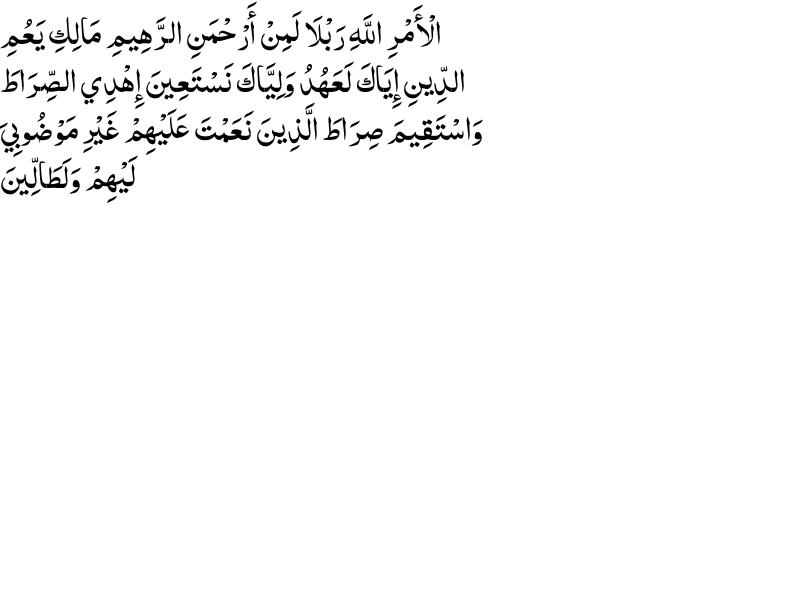

In [182]:
import re
import textwrap

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
blank_image = Image.new('RGB', (800, 600), (255,255,255))
drawing_on_img = ImageDraw.Draw(blank_image)
font = ImageFont.truetype('../assets/Al Majeed Quranic Font_shiped.ttf',size=35)
text_color = (201,50,250)
text_coordinates = (0,0)
novo = "\n".join(textwrap.wrap(tarteel_string, width=70))
drawing_on_img.text(text_coordinates, novo ,font=font,fill='black')

blank_image.save("text_on_test_imager.jpg")
display(Image.open("text_on_test_imager.jpg"))# /content/

